<a href="https://colab.research.google.com/github/ashokdhakad/Javia-assignments/blob/master/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
!pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name="Assignment-2" #will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data,so that you every participant receives a slightly different version of the dataset.Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name="Ashok" #at least 5 characters


The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,37.69125,2,no,12759.377540
752,64,male,43.59075,0,no,14778.957388
1258,55,male,43.37225,3,no,31266.123772
384,44,male,25.45525,2,no,8634.637076
406,33,female,27.95650,0,no,4352.501816


Let us answer check the dataset.

#### Q: How many rows does the dataset have?

In [ ]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


#### Q: How many columns does the dataset have

In [ ]:
num_cols = dataframe.shape[1]
print(num_cols)

6


#### Q: What are the column titles of the input variables?

In [ ]:
input_cols=list(dataframe.columns[])
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

#### Q: Which of the input columns are non-numeric or categorial variables ?
Hint: sex is one of them. List the columns that are not numbers.

In [ ]:
categorical_cols=list(dataframe.select_dtypes('O').columns)
categorical_cols

['sex', 'smoker']

#### Q: What are the column titles of output/target variable(s)?

In [ ]:
output_cols=[dataframe.columns[-1]]
output_cols

['charges']

#### Q: (Optional) What is the minimum, maximum and average value of the charges column? Can you show the distribution of values in a graph? Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

           charges
min    1166.748856
max   66321.245130
mean  13824.973050


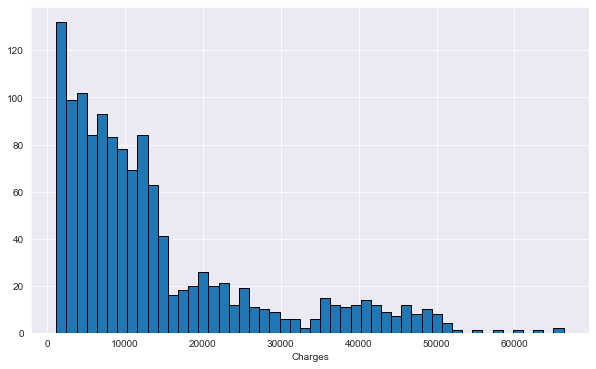

In [ ]:
# Write your answer here
print(dataframe.agg({'charges':['min','max','mean']}))
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.hist(dataframe['charges'], bins=50, ec='black')
plt.xlabel('Charges')
plt.show()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [ ]:
!pip install jovian --upgrade -q

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
import jovian

In [ ]:
jovian.commit(project='my-project')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "ashokdhakad/my-project"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/my-project


'https://jovian.ai/ashokdhakad/my-project'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.     ,  0.     , 37.69125,  2.     ,  0.     ],
        [64.     ,  1.     , 43.59075,  0.     ,  0.     ],
        [55.     ,  1.     , 43.37225,  3.     ,  0.     ],
        ...,
        [56.     ,  1.     , 29.82525,  0.     ,  0.     ],
        [18.     ,  0.     , 34.85075,  0.     ,  0.     ],
        [43.     ,  1.     , 29.9345 ,  0.     ,  0.     ]]),
 array([[12759.37754 ],
        [14778.957388],
        [31266.123772],
        ...,
        [11612.034356],
        [ 2291.885388],
        [ 7110.863448]]))

#### Q: Convert the numpy arrays inputs_array and targets_array into PyTorch tensors. Make sure that the data type is torch.float32.

In [ ]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs[:2], targets[:2]

(tensor([[55.0000,  0.0000, 37.6912,  2.0000,  0.0000],
         [64.0000,  1.0000, 43.5908,  0.0000,  0.0000]]), tensor([[12759.3779],
         [14778.9570]]))

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)
dataset[:5]

(tensor([[55.0000,  0.0000, 37.6912,  2.0000,  0.0000],
         [64.0000,  1.0000, 43.5908,  0.0000,  0.0000],
         [55.0000,  1.0000, 43.3722,  3.0000,  0.0000],
         [44.0000,  1.0000, 25.4552,  2.0000,  0.0000],
         [33.0000,  0.0000, 27.9565,  0.0000,  0.0000]]), tensor([[12759.3779],
         [14778.9570],
         [31266.1230],
         [ 8634.6367],
         [ 4352.5020]]))

#### Q: Pick a number between 0.1 and 0.2 to determine the fraction of data that will be used for creating the validation set. Then use random_split to create training & validation datasets.

In [ ]:
val_percent = 0.125 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

#### Q: Pick a batch size for the data loader.

In [ ]:
batch_size = 120

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
len(train_loader), len(val_loader)

(10, 2)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[32.0000,  0.0000, 50.8530,  0.0000,  0.0000],
        [31.0000,  0.0000, 43.8092,  1.0000,  1.0000],
        [31.0000,  0.0000, 27.1400,  2.0000,  0.0000],
        [50.0000,  0.0000, 29.4400,  0.0000,  0.0000],
        [36.0000,  0.0000, 29.7850,  1.0000,  0.0000],
        [18.0000,  1.0000, 24.6905,  0.0000,  0.0000],
        [20.0000,  1.0000, 35.2878,  0.0000,  1.0000],
        [50.0000,  1.0000, 29.0950,  0.0000,  0.0000],
        [52.0000,  0.0000, 38.2950,  2.0000,  0.0000],
        [21.0000,  1.0000, 35.7650,  0.0000,  0.0000],
        [64.0000,  1.0000, 43.9185,  0.0000,  0.0000],
        [19.0000,  0.0000, 32.6600,  1.0000,  0.0000],
        [63.0000,  0.0000, 24.9090,  0.0000,  0.0000],
        [18.0000,  1.0000, 26.5478,  0.0000,  0.0000],
        [48.0000,  1.0000, 36.1618,  1.0000,  0.0000],
        [26.0000,  1.0000, 34.5000,  1.0000,  0.0000],
        [30.0000,  0.0000, 32.6657,  1.0000,  0.0000],
        [61.0000,  1.0000, 36.3055,  0.0000,  0.0000],
  

        [18646.4746]])


Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "ashokdhakad/Assignment-2"
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/assignment-2


'https://jovian.ai/ashokdhakad/assignment-2'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
inputs.size(), targets.size()

(torch.Size([1271, 5]), torch.Size([1271, 1]))

In [ ]:
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)        
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0093,  0.0368,  0.3054,  0.2592, -0.2386]], requires_grad=True),
 Parameter containing:
 tensor([0.0784], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ashokdhakad/assignment-2" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/assignment-2


'https://jovian.ai/ashokdhakad/assignment-2'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

#### Q: Use the evaluate function to calculate the loss on the validation set before training.

In [ ]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15423.173828125}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 1000
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13885.4580
Epoch [40], val_loss: 12468.1816
Epoch [60], val_loss: 11364.5166
Epoch [80], val_loss: 10523.9160
Epoch [100], val_loss: 9942.8232
Epoch [120], val_loss: 9552.9707
Epoch [140], val_loss: 9332.9189
Epoch [160], val_loss: 9224.9395
Epoch [180], val_loss: 9160.3418
Epoch [200], val_loss: 9115.1602
Epoch [220], val_loss: 9078.2383
Epoch [240], val_loss: 9047.9492
Epoch [260], val_loss: 9020.8555
Epoch [280], val_loss: 8989.8770
Epoch [300], val_loss: 8959.9932
Epoch [320], val_loss: 8928.9492
Epoch [340], val_loss: 8894.9199
Epoch [360], val_loss: 8860.6309
Epoch [380], val_loss: 8824.2812
Epoch [400], val_loss: 8787.2871
Epoch [420], val_loss: 8750.7656
Epoch [440], val_loss: 8712.1201
Epoch [460], val_loss: 8674.1797
Epoch [480], val_loss: 8638.1768
Epoch [500], val_loss: 8601.0518
Epoch [520], val_loss: 8563.5957
Epoch [540], val_loss: 8527.9023
Epoch [560], val_loss: 8493.1279
Epoch [580], val_loss: 8464.0820
Epoch [600], val_loss: 8443.0605
Epoch [620

In [ ]:
epochs = 1000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8303.3574
Epoch [40], val_loss: 8302.9209
Epoch [60], val_loss: 8302.4746
Epoch [80], val_loss: 8301.9941
Epoch [100], val_loss: 8301.5635
Epoch [120], val_loss: 8301.1152
Epoch [140], val_loss: 8300.7031
Epoch [160], val_loss: 8300.2520
Epoch [180], val_loss: 8299.7480
Epoch [200], val_loss: 8299.2949
Epoch [220], val_loss: 8298.8887
Epoch [240], val_loss: 8298.3857
Epoch [260], val_loss: 8297.9346
Epoch [280], val_loss: 8297.4824
Epoch [300], val_loss: 8297.0391
Epoch [320], val_loss: 8296.5820
Epoch [340], val_loss: 8296.2207
Epoch [360], val_loss: 8295.7207
Epoch [380], val_loss: 8295.2305
Epoch [400], val_loss: 8294.7754
Epoch [420], val_loss: 8294.3398
Epoch [440], val_loss: 8293.8662
Epoch [460], val_loss: 8293.4238
Epoch [480], val_loss: 8292.9570
Epoch [500], val_loss: 8292.4922
Epoch [520], val_loss: 8292.0820
Epoch [540], val_loss: 8291.5908
Epoch [560], val_loss: 8291.1182
Epoch [580], val_loss: 8290.6641
Epoch [600], val_loss: 8290.2656
Epoch [620], v

In [ ]:
epochs = 1000
lr = 1e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8280.3965
Epoch [40], val_loss: 8279.9434
Epoch [60], val_loss: 8279.4766
Epoch [80], val_loss: 8278.9814
Epoch [100], val_loss: 8278.5449
Epoch [120], val_loss: 8278.0703
Epoch [140], val_loss: 8277.5586
Epoch [160], val_loss: 8277.1211
Epoch [180], val_loss: 8276.7324
Epoch [200], val_loss: 8276.1465
Epoch [220], val_loss: 8275.6816
Epoch [240], val_loss: 8275.2646
Epoch [260], val_loss: 8274.7949
Epoch [280], val_loss: 8274.3691
Epoch [300], val_loss: 8273.8721
Epoch [320], val_loss: 8273.3965
Epoch [340], val_loss: 8272.9971
Epoch [360], val_loss: 8272.4307
Epoch [380], val_loss: 8271.9648
Epoch [400], val_loss: 8271.4854
Epoch [420], val_loss: 8271.0195
Epoch [440], val_loss: 8270.5352
Epoch [460], val_loss: 8270.0664
Epoch [480], val_loss: 8269.6094
Epoch [500], val_loss: 8269.1299
Epoch [520], val_loss: 8268.6025
Epoch [540], val_loss: 8268.2031
Epoch [560], val_loss: 8267.7305
Epoch [580], val_loss: 8267.2812
Epoch [600], val_loss: 8266.7969
Epoch [620], v

In [ ]:
epochs = 1000
lr = 1e-1
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8252.6113
Epoch [40], val_loss: 8247.8711
Epoch [60], val_loss: 8243.2471
Epoch [80], val_loss: 8238.1777
Epoch [100], val_loss: 8233.7246
Epoch [120], val_loss: 8228.2500
Epoch [140], val_loss: 8223.7480
Epoch [160], val_loss: 8218.3447
Epoch [180], val_loss: 8214.0352
Epoch [200], val_loss: 8209.2217
Epoch [220], val_loss: 8203.5254
Epoch [240], val_loss: 8199.1562
Epoch [260], val_loss: 8194.2949
Epoch [280], val_loss: 8188.6572
Epoch [300], val_loss: 8183.6245
Epoch [320], val_loss: 8179.3613
Epoch [340], val_loss: 8173.5322
Epoch [360], val_loss: 8168.9619
Epoch [380], val_loss: 8163.2412
Epoch [400], val_loss: 8158.6963
Epoch [420], val_loss: 8153.4570
Epoch [440], val_loss: 8148.1123
Epoch [460], val_loss: 8143.4756
Epoch [480], val_loss: 8137.7505
Epoch [500], val_loss: 8132.1543
Epoch [520], val_loss: 8126.7305
Epoch [540], val_loss: 8121.5947
Epoch [560], val_loss: 8116.6167
Epoch [580], val_loss: 8111.2549
Epoch [600], val_loss: 8106.0029
Epoch [620], v

In [ ]:
epochs = 3000
lr = 1e-1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7991.8281
Epoch [40], val_loss: 7986.7236
Epoch [60], val_loss: 7981.4375
Epoch [80], val_loss: 7976.0381
Epoch [100], val_loss: 7970.6963
Epoch [120], val_loss: 7965.3818
Epoch [140], val_loss: 7959.9482
Epoch [160], val_loss: 7954.7988
Epoch [180], val_loss: 7949.8052
Epoch [200], val_loss: 7943.6592
Epoch [220], val_loss: 7938.8936
Epoch [240], val_loss: 7933.5713
Epoch [260], val_loss: 7928.5068
Epoch [280], val_loss: 7923.0371
Epoch [300], val_loss: 7917.4453
Epoch [320], val_loss: 7912.5288
Epoch [340], val_loss: 7907.0244
Epoch [360], val_loss: 7902.1997
Epoch [380], val_loss: 7896.7793
Epoch [400], val_loss: 7891.6294
Epoch [420], val_loss: 7886.0059
Epoch [440], val_loss: 7881.3071
Epoch [460], val_loss: 7876.0718
Epoch [480], val_loss: 7870.5562
Epoch [500], val_loss: 7865.0830
Epoch [520], val_loss: 7859.9849
Epoch [540], val_loss: 7854.4590
Epoch [560], val_loss: 7849.2183
Epoch [580], val_loss: 7843.9824
Epoch [600], val_loss: 7838.7383
Epoch [620], v

#### Q: What is the final validation loss of your model?

In [ ]:
val_loss = history5[-1]['val_loss']
val_loss

7215.9287109375

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ashokdhakad/assignment-2" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/assignment-2


'https://jovian.ai/ashokdhakad/assignment-2'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 38.5653,  0.0000,  1.0000])
Target: tensor([36002.5547])
Prediction: tensor(6181.1362)


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([23.0000,  1.0000, 19.9928,  1.0000,  0.0000])
Target: tensor([2886.2000])
Prediction: tensor(3449.5928)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ashokdhakad/assignment-2" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/assignment-2


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ashokdhakad/assignment-2" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/assignment-2


'https://jovian.ai/ashokdhakad/assignment-2'

In [ ]:
jovian.submit(project='my-project',assignment="zerotogans-a2")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "ashokdhakad/my-project" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ashokdhakad/my-project
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model
